In [1]:
from IPython.core.display import HTML
import os
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from scikit_mol.fingerprints import MorganFingerprintTransformer
from scikit_mol.conversions import SmilesToMolTransformer
from scikit_mol.standardizer import Standardizer
from scikit_mol.descriptors import MolecularDescriptorTransformer


In [2]:
import torch

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit.Chem.rdFingerprintGenerator as rdFingerprintGenerator

#from rdkit.Chem.rdFingerprintGenerator import MorganFingerprintGenerator


In [20]:
import yaml

# Path to your config file
CONFIG_PATH = r"D:\Skills\new\NeurIPS2\config.yaml"

# Load it
with open(CONFIG_PATH, 'r') as file:
    config = yaml.safe_load(file)


In [4]:
ffv_merged = config['output']['ffv_merged_csv']
Tc_cleaned = config['output']['Tc_csv']
Tg_cleaned = config['output']['Tg_csv']



In [5]:
ffv_merged_df = pd.read_csv(ffv_merged)


In [6]:
ffv_merged_df.head()

,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817.0,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919.0,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772.0,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416.0,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187.0,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


In [7]:
ffv_merged_df.isna().sum()

id          862
SMILES        0
Tg         7891
FFV           0
Tc         7592
Density    7622
Rg         7622
dtype: int64

In [8]:
ffv_merged_df.count()

id         7030
SMILES     7892
Tg            1
FFV        7892
Tc          300
Density     270
Rg          270
dtype: int64

In [9]:
Tc_cleaned_df = pd.read_csv(Tc_cleaned)

In [10]:
Tc_cleaned_df.isna().sum()

id         130
SMILES       0
Tg         835
FFV        567
Tc         130
Density    336
Rg         332
dtype: int64

In [11]:
Tc_cleaned_df.count()

id         737
SMILES     867
Tg          32
FFV        300
Tc         737
Density    531
Rg         535
dtype: int64

In [12]:
Tc_cleaned_df.dropna(subset='Tc', inplace=True)

In [13]:
Tg_cleaned_df = pd.read_csv(Tg_cleaned)

Tg_cleaned_df.tail()


,id,SMILES,Tg,FFV,Tc,Density,Rg
552,NaN,*c1ccc(*)c2nccnc12,216.378732,NaN,NaN,NaN,NaN
553,NaN,*c1ccc(-c2ccc(N3C(=O)c4ccc(-c5ccc6c(c5)C(=O)N(...,421.982243,NaN,NaN,NaN,NaN
554,NaN,*c1ccc(C(=O)CNc2ccc(NCC(=O)c3ccc(S(*)(=O)=O)cc...,198.902674,NaN,NaN,NaN,NaN
555,NaN,*c1ccc2c(c1)C(=O)N(c1c(F)c(F)c(N3C(=O)c4ccc(C(...,388.013746,NaN,NaN,NaN,NaN
556,NaN,*c1cccc(N2C(=O)c3ccc(Oc4ccc5c(c4)C(C)(c4ccc(Oc...,231.956044,NaN,NaN,NaN,NaN


In [14]:
Tg_cleaned_df.isna().sum()

id          46
SMILES       0
Tg           0
FFV        556
Tc         525
Density    533
Rg         533
dtype: int64

Perfect — here’s a step-by-step pipeline for:

✅ 1. Generating RDKit fingerprints from your ffv_merged_df

✅ 2. Assigning unique IDs and keeping SMILES for traceability

✅ 3. Converting fingerprints to tensors

✅ 4. Saving as .pt files

✅ 5. Loading later for model use

In [18]:
# RDKit fingerprint generator
generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)

def smiles_to_fp_tensor(smiles, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros((nBits,), dtype=np.float32)
    fp_sparse = generator.GetCountFingerprint(mol)
    arr = np.zeros((nBits,), dtype=np.float32)
    for idx, count in fp_sparse.GetNonzeroElements().items():
        if idx < nBits:
            arr[idx] = float(count)
    return arr


In [25]:
def prepare_rdkit_tensor_dataset(df, output_path_pt, output_path_meta):
    smiles_list = df['SMILES'].str.strip().tolist()
    ids = list(range(len(smiles_list)))  # assign unique integer IDs

    # Compute fingerprint vectors
    fps = np.stack([smiles_to_fp_tensor(smi) for smi in smiles_list])
    fps_tensor = torch.tensor(fps, dtype=torch.float32)  # shape: [n, 1024]

    # Save tensor
    torch.save(fps_tensor, output_path_pt)

    print(fps_tensor[0])           # First molecule's fingerprint
    print(fps_tensor[0][:10])      # First 10 bits of the first fingerprint
    print(torch.sum(fps_tensor, dim=1))  # Sum of each fingerprint — should not be all 0

    zero_rows = torch.sum(fps_tensor, dim=1) == 0
    print(f"All-zero fingerprints: {zero_rows.sum().item()} out of {fps_tensor.shape[0]}")



    # Save meta (SMILES and ID mapping)
    meta_df = pd.DataFrame({
        'id': ids,
        'SMILES': smiles_list,
        'FFV': df['FFV'].values
    })
    meta_df.to_csv(output_path_meta, index=False)

    print(f"Saved: {output_path_pt}, Metadata: {output_path_meta}")
    return fps_tensor, meta_df


In [26]:
rdkit_ffv_pt = config['output']['rdkit_ffv']
rdkit_ffv_meta = config['output']['rdkit_ffv_meta']

In [27]:
fps_tensor, meta_df = prepare_rdkit_tensor_dataset(
    ffv_merged_df,
    output_path_pt= rdkit_ffv_pt,
    output_path_meta=  rdkit_ffv_meta

)


tensor([0., 1., 0.,  ..., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([ 53., 136., 218.,  ..., 120., 171., 158.])
All-zero fingerprints: 0 out of 7892
Saved: D:\Skills\new\NeurIPS2\outputs\torch_tensor\rdkit_ffv.pt, Metadata: D:\Skills\new\NeurIPS2\outputs\csv\rdkit_ffv_meta.csv


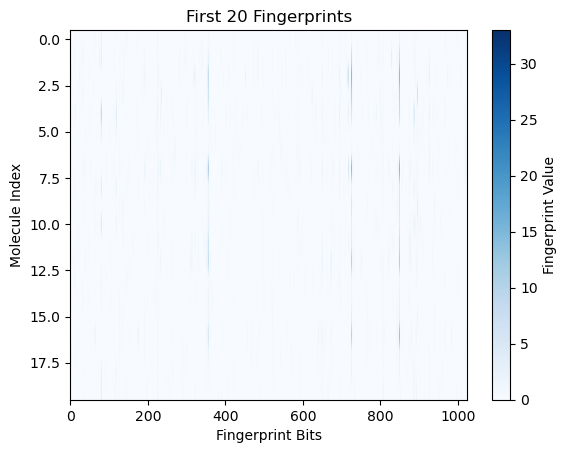

In [28]:
import matplotlib.pyplot as plt

plt.imshow(fps_tensor[:20].numpy(), aspect='auto', cmap='Blues')
plt.colorbar(label="Fingerprint Value")
plt.title("First 20 Fingerprints")
plt.xlabel("Fingerprint Bits")
plt.ylabel("Molecule Index")
plt.show()


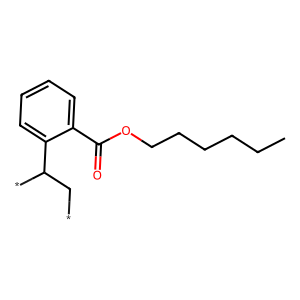

In [29]:
from rdkit import Chem
from rdkit.Chem import Draw

sample_smiles = ffv_merged_df['SMILES'].iloc[0]
mol = Chem.MolFromSmiles(sample_smiles)
Draw.MolToImage(mol)  # to see what molecule you're fingerprinting


In [24]:

# Load the saved file (dict or tensor)
data = torch.load(rdkit_ffv_pt)

# Inspect keys (if saved as a dict)
if isinstance(data, dict):
    print("Keys in .pt file:", list(data.keys()))
    for key, val in data.items():
        print(f"\n--- {key} ---")
        print("Type:", type(val))
        if isinstance(val, torch.Tensor):
            print("Shape:", val.shape)
            print("Dtype:", val.dtype)
            print("Sample:\n", val[:5])  # Show first 5 rows
        elif isinstance(val, list):
            print("Sample:\n", val[:5])
        elif isinstance(val, dict):
            print("Keys:", list(val.keys()))
else:
    # If just a tensor
    print("Loaded tensor:")
    print("Shape:", data.shape)
    print("Dtype:", data.dtype)
    print("Sample:\n", data[0])


Loaded tensor:
Shape: torch.Size([7892, 1024])
Dtype: torch.float32
Sample:
 tensor([0., 1., 0.,  ..., 0., 0., 0.])
